In [32]:
import urllib3

def get_request(uri):
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [33]:
import json

from bs4 import BeautifulSoup


with open('URL.json',"r") as f:
    urls = json.load(f)

DATA = list(map(lambda x: [x['name'],x['URL'],x['HTML'],x['class']],urls['periodicos']))

textos=[]
for dato in DATA:
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    textos.append(list(map(lambda x:x.text,soup.find_all(dato[2],{"class":dato[3]}))))

In [34]:
textoLimpio = []
caracterBasura="\n"
textosSinCaracterBasura=[]
for value in textos:
    textosSinCaracterBasura.append([x.replace(caracterBasura,'') for x in value])

for index,value in enumerate(textos):
    textoLimpio.append(list(map(lambda x:" ".join(list(filter(lambda y:len(str(y))>3,(x.split(" "))))),textosSinCaracterBasura[index])))

In [35]:
textoUnido = [y for x in textoLimpio for y in x]

In [36]:
# Menos óptimo

# PALABRA CON VALOR
palabraValor={}

# FRASES CON MÁS PUNTUACIÓN
frasesTotalValor=[]

for frase in textoUnido:
    fraseValores=[]
    for palabra in frase.split(" "):
        valor=0
        for frase in textoUnido:
            valor+=frase.count(palabra)
        palabraValor[palabra.lower()] = valor
        fraseValores.append(valor)
    frasesTotalValor.append(sum(fraseValores)/len(fraseValores))

In [37]:
frasesTotalValor = list(map(lambda x:x/max(frasesTotalValor),frasesTotalValor))
frasesTotalValor

[0.13001605136436598,
 0.06741573033707865,
 0.4087078651685393,
 0.05243445692883895,
 0.5008025682182986,
 0.04044943820224719,
 0.08764044943820225,
 0.13146067415730336,
 0.0800561797752809,
 0.3471910112359551,
 0.07704654895666131,
 0.4741573033707865,
 0.07078651685393259,
 0.1348314606741573,
 0.10533707865168539,
 0.08089887640449438,
 0.14157303370786517,
 0.08667736757624399,
 0.08186195826645264,
 0.23595505617977527,
 0.12257405515832481,
 0.07584269662921347,
 0.09691011235955056,
 0.0749063670411985,
 0.3808988764044944,
 0.07584269662921347,
 0.06260032102728733,
 0.033707865168539325,
 0.07752808988764044,
 0.033707865168539325,
 0.033707865168539325,
 0.11797752808988764,
 0.033707865168539325,
 0.033707865168539325,
 0.09630818619582664,
 0.05337078651685393,
 0.10112359550561797,
 0.12520064205457465,
 0.4307116104868914,
 0.18117977528089887,
 0.061287027579162406,
 0.04634831460674157,
 0.36300777873811585,
 0.11235955056179775,
 0.10112359550561797,
 0.0561797752

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'para'),
  Text(1, 0, 'acción'),
  Text(2, 0, 'ante'),
  Text(3, 0, 'madrid'),
  Text(4, 0, 'esta'),
  Text(5, 0, 'comentario'),
  Text(6, 0, 'comentarios'),
  Text(7, 0, 'tras'),
  Text(8, 0, 'barça'),
  Text(9, 0, 'contra')])

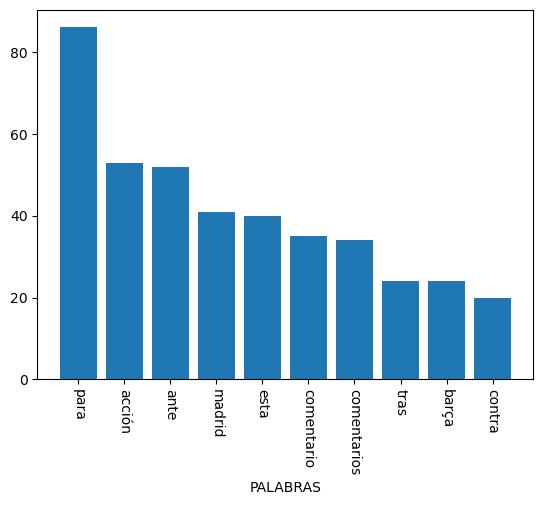

In [38]:
import matplotlib.pyplot as plt
from pandas import DataFrame

diccionario_ordenado = sorted(palabraValor.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])

plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)